In [1]:
import os
import matplotlib.pyplot as plt
import torch
os.chdir("..")
from src.cpwc.tools.ptychography import Ptychography as Ptychography
from src.cpwc.multires.class_multiressolver import *
from src.cpwc.multires.class_multires import *
from src.cpwc.tools.utils import *
torch.cuda.empty_cache()

# Set seeds 
torch.manual_seed(0)
np.random.seed(0)


/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def unwrap_2d(phase):
    """
    Unwraps a 2D phase array using NumPy's 1D unwrap function.
    
    Parameters:
    phase (numpy array): The 2D phase array to be unwrapped.
    
    Returns:
    unwrapped_phase (numpy array): The 2D unwrapped phase array.
    """
    # Unwrap along the first axis (rows)
    unwrapped_phase = np.unwrap(phase, axis=0)
    
    # Unwrap along the second axis (columns)
    unwrapped_phase = np.unwrap(unwrapped_phase, axis=1)
    
    return unwrapped_phase

In [3]:
max_scale = 7
max_probe_size = 32
max_shift = 8
device = 'cuda'
I_in = 15*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 20*np.array([0, 0, 0, 30, 30,40,80])
cycle = [0, -1, -1, -1,  1, 1, 1]
lmbda = 0
LR = 1e-1
tol = [1e-10] * 9
tol_in = [1e-10] * 9

linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)

image = plt.imread('test_data/peppers_reduced.jpg')/ 255 
image_tensor = torch.tensor(image).double().view(1, 1, 2**max_scale, 2**max_scale).to(torch.complex128)
x = torch.exp(1j * image_tensor).to(device)


In [4]:
y = linOperator.apply(x)

Scale: 7, n_copies: 1


In [5]:
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) and obj.is_cuda:
            print(type(obj), obj.size())
    except Exception:
        pass

<class 'torch.Tensor'> torch.Size([1, 289, 128, 128])
<class 'torch.Tensor'> torch.Size([1, 1, 128, 128])
<class 'torch.Tensor'> torch.Size([128, 128])
<class 'torch.Tensor'> torch.Size([128, 128])
<class 'torch.Tensor'> torch.Size([128, 128])


/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:181: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


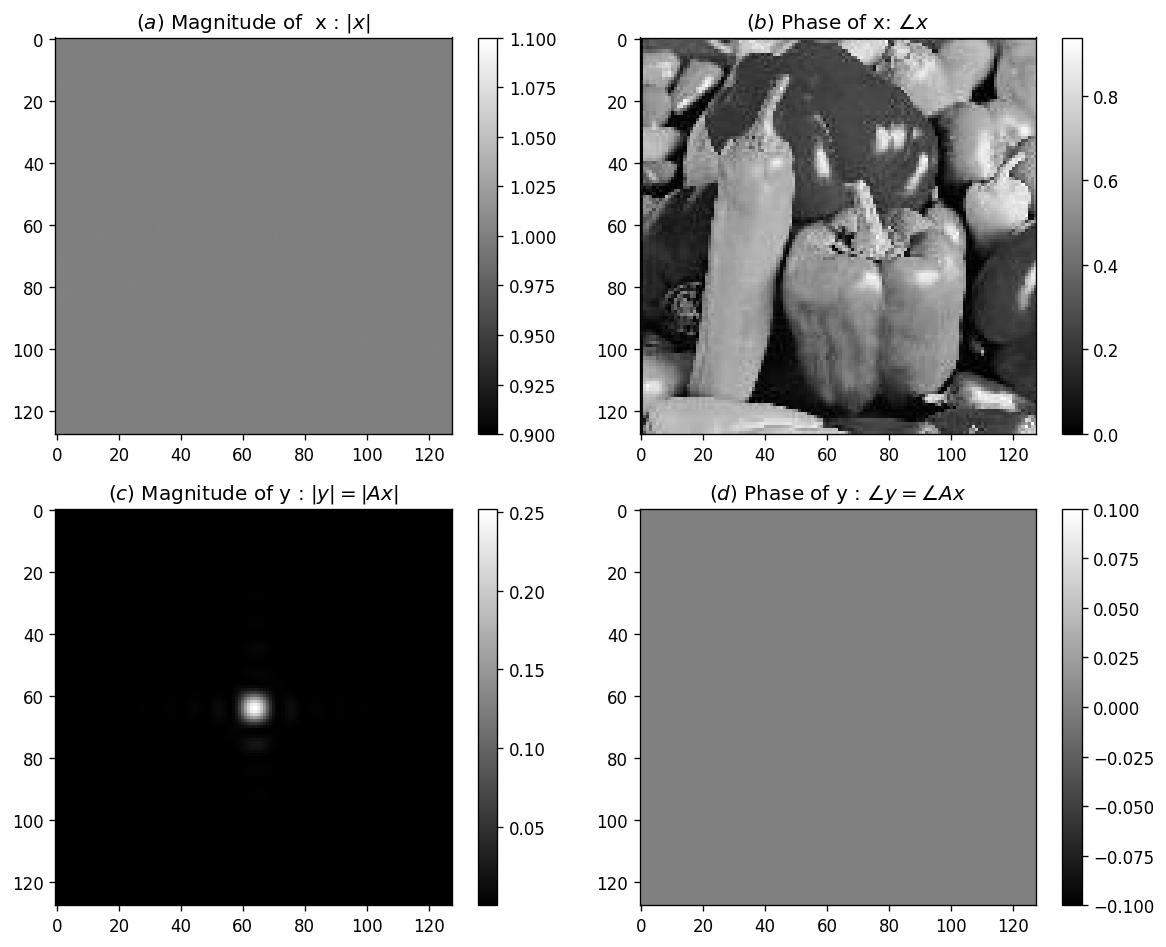

In [6]:
plt.figure(figsize=(10, 8),dpi = 120)    
plt.subplot(2, 2, 1)
plt.imshow(np.abs(x.cpu().numpy().squeeze()), cmap='gray')
plt.colorbar()
plt.title(r"$(a)$ Magnitude of  x : $|x|$")
plt.subplot(2, 2, 2)
plt.imshow(np.angle(x.cpu().numpy().squeeze()), cmap='gray')
plt.colorbar()
plt.title(r"$(b)$ Phase of x: $\angle x$")
plt.subplot(2, 2, 3)
plt.imshow(np.abs(y[:,0,:,:].cpu().numpy().squeeze()), cmap='gray')
plt.colorbar()
plt.title(r"$(c)$ Magnitude of y : $|y| = |Ax|$")
plt.subplot(2, 2, 4)
angy = np.angle(y[:,0,:,:].cpu().numpy().squeeze())
plt.imshow(angy, cmap='gray')
plt.colorbar()
plt.title(r"$(d)$ Phase of y : $\angle y = \angle Ax$")
plt.tight_layout()
plt.show()

In [7]:
y = linOperator.apply_linop(x)
x_recon = linOperator.apply_linopT(y)

In [8]:
y.shape

torch.Size([1, 289, 128, 128])

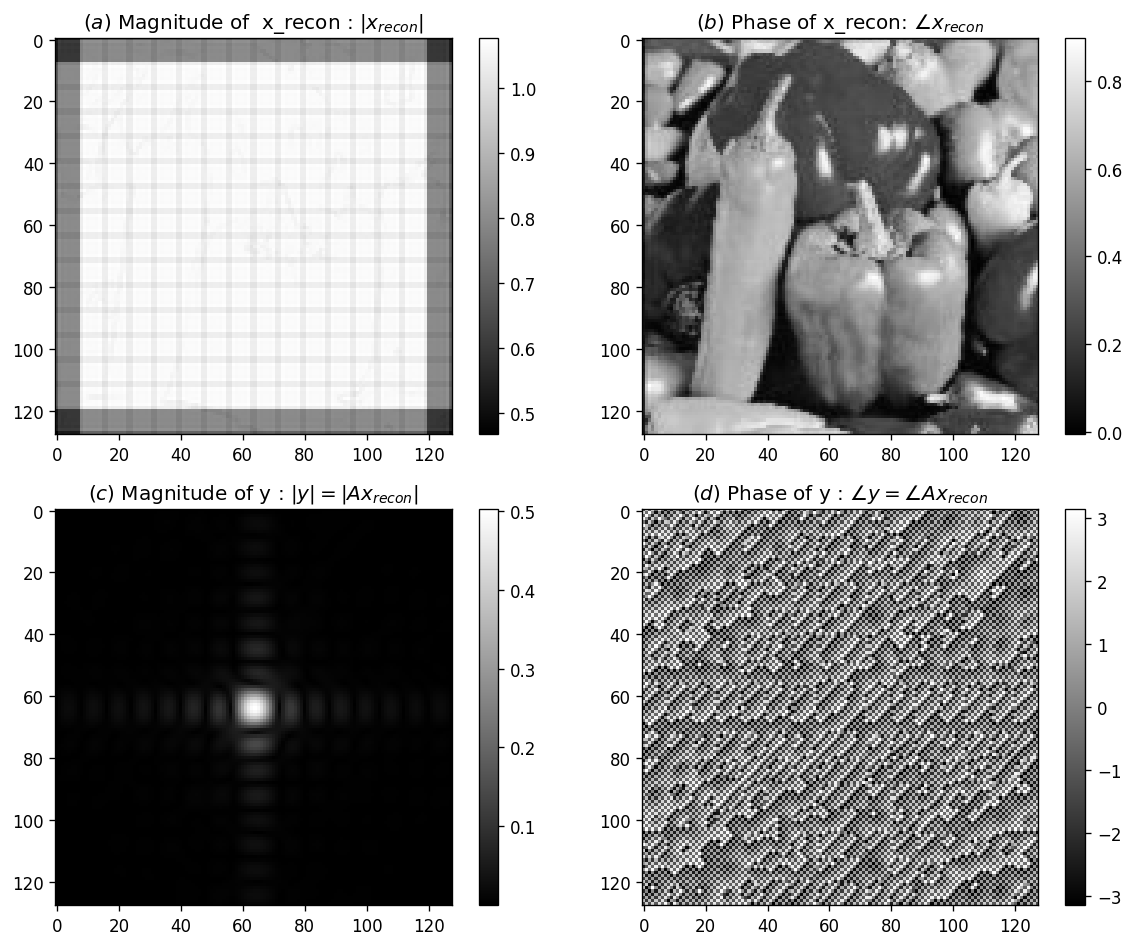

In [9]:
plt.figure(figsize=(10, 8),dpi = 120)
plt.subplot(2, 2, 1)
plt.imshow(np.abs(x_recon.cpu().numpy().squeeze()), cmap='gray')
plt.colorbar()
plt.title(r"$(a)$ Magnitude of  x_recon : $|x_{recon}|$")
plt.subplot(2, 2, 2)
a = np.angle(x_recon.cpu().numpy().squeeze())
plt.imshow(a, cmap='gray')
plt.colorbar()
plt.title(r"$(b)$ Phase of x_recon: $\angle x_{recon}$")
plt.subplot(2, 2, 3)
plt.imshow(np.abs(y[:,0,:,:].cpu().numpy().squeeze()), cmap='gray')
plt.colorbar()
plt.title(r"$(c)$ Magnitude of y : $|y| = |Ax_{recon}|$")
plt.subplot(2, 2, 4)
plt.imshow(np.angle(y[:,0,:,:].cpu().numpy().squeeze()), cmap='gray')
plt.colorbar()
plt.title(r"$(d)$ Phase of y : $\angle y = \angle Ax_{recon}$")
plt.tight_layout()


In [10]:
scale = 7
x = torch.randn(1, 1, 2**scale, 2**scale).to(torch.complex128).to(device)
y = torch.randn(1, 289, 2**scale, 2**scale).to(torch.complex128).to(device)

v1 = torch.sum(x.conj()*linOperator.apply_linopT(y))
v2 = torch.sum(y*linOperator.apply_linop(x).conj())

In [11]:
v1

tensor(-72.2401-2.1164j, device='cuda:0', dtype=torch.complex128)

In [12]:
v2

tensor(-72.2401-2.1164j, device='cuda:0', dtype=torch.complex128)

In [13]:
#The operator is proper

In [14]:
#Effect of upscaling 
M = MultiRes(7,"cuda")
scale = 5
x = torch.randn(1, 1, 2**scale, 2**scale).to(torch.complex128).to(device)
x_u = M.up(x)

In [15]:
y_u = linOperator.apply_linop(x_u)
y = linOperator.apply_linop(x) 

Scale: 6, n_copies: 2
Scale: 5, n_copies: 4


In [16]:
x_u

tensor([[[[ 0.2057+0.j,  0.2057+0.j,  0.9722+0.j,  ...,  1.4332+0.j, -0.2984+0.j,
           -0.2984+0.j],
          [ 0.2057+0.j,  0.2057+0.j,  0.9722+0.j,  ...,  1.4332+0.j, -0.2984+0.j,
           -0.2984+0.j],
          [ 1.1586+0.j,  1.1586+0.j,  0.0236+0.j,  ..., -0.7460+0.j, -0.6446+0.j,
           -0.6446+0.j],
          ...,
          [-1.9989+0.j, -1.9989+0.j,  0.9942+0.j,  ...,  0.8555+0.j,  0.7055+0.j,
            0.7055+0.j],
          [ 1.7666+0.j,  1.7666+0.j,  0.4649+0.j,  ...,  0.4224+0.j,  0.0156+0.j,
            0.0156+0.j],
          [ 1.7666+0.j,  1.7666+0.j,  0.4649+0.j,  ...,  0.4224+0.j,  0.0156+0.j,
            0.0156+0.j]]]], device='cuda:0', dtype=torch.complex128)

In [17]:
x_u

tensor([[[[ 0.2057+0.j,  0.2057+0.j,  0.9722+0.j,  ...,  1.4332+0.j, -0.2984+0.j,
           -0.2984+0.j],
          [ 0.2057+0.j,  0.2057+0.j,  0.9722+0.j,  ...,  1.4332+0.j, -0.2984+0.j,
           -0.2984+0.j],
          [ 1.1586+0.j,  1.1586+0.j,  0.0236+0.j,  ..., -0.7460+0.j, -0.6446+0.j,
           -0.6446+0.j],
          ...,
          [-1.9989+0.j, -1.9989+0.j,  0.9942+0.j,  ...,  0.8555+0.j,  0.7055+0.j,
            0.7055+0.j],
          [ 1.7666+0.j,  1.7666+0.j,  0.4649+0.j,  ...,  0.4224+0.j,  0.0156+0.j,
            0.0156+0.j],
          [ 1.7666+0.j,  1.7666+0.j,  0.4649+0.j,  ...,  0.4224+0.j,  0.0156+0.j,
            0.0156+0.j]]]], device='cuda:0', dtype=torch.complex128)

In [18]:
x

tensor([[[[ 0.2057+0.j,  0.9722+0.j,  1.1324+0.j,  ..., -1.1685+0.j,  1.4332+0.j,
           -0.2984+0.j],
          [ 1.1586+0.j,  0.0236+0.j, -0.3753+0.j,  ..., -1.1129+0.j, -0.7460+0.j,
           -0.6446+0.j],
          [-1.4374+0.j, -0.8182+0.j,  1.4686+0.j,  ..., -0.8764+0.j,  0.2422+0.j,
            0.0230+0.j],
          ...,
          [-1.5408+0.j,  0.5830+0.j,  1.1639+0.j,  ..., -0.5417+0.j, -0.6693+0.j,
           -1.8223+0.j],
          [-1.9989+0.j,  0.9942+0.j,  1.5038+0.j,  ..., -0.4164+0.j,  0.8555+0.j,
            0.7055+0.j],
          [ 1.7666+0.j,  0.4649+0.j, -0.8635+0.j,  ...,  1.2780+0.j,  0.4224+0.j,
            0.0156+0.j]]]], device='cuda:0', dtype=torch.complex128)

In [19]:
y

tensor([[[[-1.7985e-07+3.5774e-08j,  1.3775e-07-2.3480e-06j,
           -8.2227e-07+7.5957e-06j,  ...,
            5.0886e-06+6.6015e-06j, -1.1987e-06-2.1914e-06j,
           -8.9064e-13-1.8377e-12j],
          [ 5.3212e-07+1.6043e-06j, -8.5523e-07+1.5264e-06j,
            4.2859e-06-1.1268e-05j,  ...,
           -6.1804e-06-1.4846e-05j,  1.7663e-06+5.2673e-06j,
            1.8383e-12+6.0791e-12j],
          [-2.6682e-07-5.5412e-06j, -2.1895e-07+4.1166e-06j,
           -5.8477e-06+7.4245e-06j,  ...,
            4.7729e-06+2.0649e-05j, -2.1862e-06-8.6666e-06j,
           -2.5290e-12-1.3213e-11j],
          ...,
          [-3.5226e-06-5.0679e-06j,  4.7777e-06+1.3412e-05j,
           -3.3819e-06-2.0448e-05j,  ...,
           -7.6352e-06-3.8343e-07j, -6.2503e-07-8.4912e-08j,
           -5.6166e-12-4.2444e-12j],
          [ 6.1269e-07+1.7071e-06j, -1.0242e-06-4.9611e-06j,
            1.2967e-06+8.8435e-06j,  ...,
            5.9595e-06+1.8359e-06j, -8.8117e-07-4.9399e-07j,
            5.045

In [20]:
y_u

tensor([[[[ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
            0.0000e+00+0.0000e+00j,  ...,
            0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
           -0.0000e+00+0.0000e+00j],
          [ 0.0000e+00+0.0000e+00j, -4.7271e-08-3.3720e-08j,
            4.0882e-08+1.4854e-07j,  ...,
           -6.9292e-08-2.4823e-07j, -2.4039e-08+7.6979e-08j,
           -5.0609e-14+4.0162e-14j],
          [ 0.0000e+00+0.0000e+00j,  1.3201e-07+9.6283e-08j,
           -1.0468e-07-3.4201e-07j,  ...,
            2.0580e-08+9.9761e-07j,  1.4494e-07-2.6143e-07j,
            1.9551e-13-1.1363e-13j],
          ...,
          [ 0.0000e+00+0.0000e+00j,  2.9084e-07+4.1321e-08j,
           -8.7310e-07-6.2576e-07j,  ...,
           -3.8656e-09+1.2258e-07j,  2.7412e-08-8.7655e-08j,
            9.3077e-14-9.8885e-14j],
          [ 0.0000e+00+0.0000e+00j, -8.0164e-08-2.7468e-08j,
            1.9316e-07+2.2813e-07j,  ...,
           -4.2415e-08-6.2720e-08j, -3.7684e-09+3.7308e-08j,
           -3.096